# Команда \#N/A
## Участник - Әділхан Оспанов




In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats.mstats import winsorize

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import smote_variants as sv

from boruta import BorutaPy
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import (
    confusion_matrix, roc_auc_score, precision_score, recall_score, accuracy_score, 
    f1_score, roc_curve, auc, precision_recall_curve
)
from scipy.stats import ks_2samp

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import openpyxl


# Приложение 1 часть
## Чистка данных  

Датасет содержал большое количество `"-"` и пустых значений, поэтому:  
- Пустые значения интерпретированы как **NaN**.  
- `"-"` заменено на **0**, так как это, вероятно, пропущенные числовые данные.  

### 🔹 Функция `preprocess_data()`  
Эта функция выполняет:  
1. **Замены значений**  
   - `"-"` → `0`  
   - Пустые значения → `NaN`  
2. **Трансформацию данных** в корректный формат.  
3. **Подготовку к импутации** (заполнению пропущенных значений).  

Эти шаги помогают улучшить качество данных и повысить стабильность моделей машинного обучения.  


In [5]:
data2 = pd.read_excel("Dataset.xlsx", engine="openpyxl")  
# Preprocessing
def preprocess_data(df):
    # Remove spaces and replace "-" with 0, then convert to numeric
    df = df.applymap(lambda x: str(x).strip().replace(" ", "").replace("-", "0"))
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

data3 = preprocess_data(data2)

## Создание производных переменных и обработка данных  

Функция `create_derived_features()` формирует новые признаки на основе имеющихся данных, что может улучшить качество модели за счет учета дополнительных зависимостей.

### 🔹 Какие признаки создаются?  

#### **Финансовые показатели**  
- `loan_to_term_ratio` – отношение суммы займа к сроку кредита.  
- `log_total_amount` – логарифм суммы займа (уменьшает влияние выбросов).  

#### **Просрочки**  
- `overdue_ratio` – доля просроченных дней от общего срока кредита.  
- `max_monthly_overdue` – максимальная просрочка за месяц.  
- `sum_monthly_overdue` – сумма всех месячных просрочек.  
- `mean_monthly_overdue` – среднее значение просрочек за месяц.  

#### **Количество контрактов**  
- `total_contracts` – общее число контрактов заемщика.  
- `contract_ratio` – доля контрактов в БВУ от всех кредитов.  

#### **Семейное положение и иждивенцы**  
- `dependants_total` – общее число иждивенцев.  
- `dependants_ratio` – отношение числа иждивенцев к возрасту заемщика.  

#### **Запросы в БДКИ (бюро кредитных историй)**  
- `query_trend` – отношение числа запросов за 3 дня к числу запросов за месяц (может отражать недавнюю активность заемщика).  

---

### 🔹 Обработка данных  
1. **Заменяем бесконечные значения (`inf, -inf`) на `NaN`** – это необходимо, так как деление на ноль может привести к бесконечным значениям.  
2. **Импутация (заполнение пропущенных значений)**  
   - Используется метод **MICE (Multiple Imputation by Chained Equations)** через `IterativeImputer`.  
   - Импутатор обучается на всех числовых данных (`numeric_cols`) и заполняет пропуски на основе корреляций между признаками.  

Этот подход позволяет улучшить качество модели, сохраняя максимум информации из имеющихся данных.  


In [6]:
def create_derived_features(df):
    df['loan_to_term_ratio'] = df['total_amount_kzt'] / df['term']  # Сумма займа / срок
    df['log_total_amount'] = np.log1p(df['total_amount_kzt'])  # Логарифм суммы займа
    
    df['overdue_ratio'] = df['overdueinstalmentcount_po_subektu'] / df['term']  # Дни просрочки / срок
    df['max_monthly_overdue'] = df[[col for col in df.columns if 'MONTH_OVERDUE_C' in col]].max(axis=1)  # Макс. просрочка за месяц
    df['sum_monthly_overdue'] = df[[col for col in df.columns if 'MONTH_OVERDUE_C' in col]].sum(axis=1)  # Сумма всех просрочек
    df['mean_monthly_overdue'] = df[[col for col in df.columns if 'MONTH_OVERDUE_C' in col]].mean(axis=1)  # Среднее значение
    
    df['total_contracts'] = df[['NUM_CONTRACT_BVU', 'NUM_CONTRACT_MFO', 'NUM_CONTRACT_PDL', 'NUM_CONTRACT_OTHERS']].sum(axis=1)
    df['contract_ratio'] = df['NUM_CONTRACT_BVU'] / df['total_contracts'].replace(0, np.nan)  # Доля контрактов в БВУ
    
    df['dependants_total'] = df['DEPENDANTS_LT18'] + df['DEPENDANTS_GT18']  # Общее число иждивенцев
    df['dependants_ratio'] = df['dependants_total'] / df['AGE'].replace(0, np.nan)  # Иждивенцы на возраст
    return df
data3 = create_derived_features(data3)

numeric_cols = data3.select_dtypes(include=[np.number]).columns

# Заменяем бесконечные значения на NaN
data3[numeric_cols] = data3[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Определяем колонки для импутации MICE
cols_to_impute_mice = []
for col in numeric_cols:
    if data3[col].nunique() > 15:
        cols_to_impute_mice.append(col)

# Определяем колонки для обработки как категориальные
cols_to_treat_as_categorical = []
for col in numeric_cols: # Добавляем и числовые
    if data3[col].nunique() <= 15:
        cols_to_treat_as_categorical.append(col)

# Инициализируем и применяем IterativeImputer (MICE)
mice_imputer = IterativeImputer(max_iter=10, random_state=42)
data3[cols_to_impute_mice] = mice_imputer.fit_transform(data3[cols_to_impute_mice])
for col in cols_to_treat_as_categorical:
    data3[col] = data3[col].fillna(data3[col].mode()[0])


## Функция `calculate_woe_iv()`  

Функция `calculate_woe_iv()` вычисляет **Weight of Evidence (WoE)** и **Information Value (IV)** для категориальных признаков, помогая определить их предсказательную силу.  

### 🔹 Как выбираются категориальные переменные?  
- В анализ включены только переменные с числом уникальных значений **меньше 150–200**.  
- Это позволяет избежать слишком разреженных категорий и улучшить интерпретируемость.  

### 🔹 Отбор признаков в модель  
- Оставлены только переменные с **IV > 0.05**, поскольку они обладают достаточной информативностью для прогнозирования.  
- Признаки с **низким IV** исключены, так как они слабо связаны с целевой переменной.  


In [11]:
def calculate_woe_iv(data, feature, target):
    df = data[[feature, target]].copy()
    
    if data[feature].dtype in [np.float64, np.int64]:
        df[feature] = pd.qcut(df[feature], q=10, duplicates='drop')

    grouped = df.groupby(feature)[target].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    
    grouped['good'] = grouped['total'] - grouped['bad']
    
    grouped['%bad'] = grouped['bad'] / grouped['bad'].sum()
    grouped['%good'] = grouped['good'] / grouped['good'].sum()
    
    grouped['WoE'] = np.log(grouped['%good'] / grouped['%bad']).replace({np.inf: 0, -np.inf: 0})
    
    grouped['IV'] = (grouped['%good'] - grouped['%bad']) * grouped['WoE']
    
    iv = grouped['IV'].sum()
    
    return grouped[['WoE', 'IV']], iv

target = 'GB_flag'  
features = [
    'was_canceled', 'GENDER', 'CLASSIFICATION', 'RESIDENCY', 'EDUCATION', 'MARITALSTATUS',
    'NEGATIVESTATUS', 'PROFESSION', 'ECONOMYACTIVITYGROUP', 'EMPLOYMENTNATURE', 'DEPENDANTS_LT18',
    'DEPENDANTS_GT18', 'AGE', 'NUM_CONTRACT_BVU', 'NUM_CONTRACT_MFO', 'NUM_CONTRACT_PDL',
    'NUM_CONTRACT_OTHERS', 'NUM_COLLATERAL', 'NUM_USAGES', 'CNT_1M', 'CNT_3M', 'CNT_6M',
    'MAX_PEAKS_OVERDUECOUNT_LAST_2Y', 'MEAN_PEAKS_OVERDUECOUNT_LAST_2Y', 'MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y',
    'SUM_SIG_PEAKS_OVERDUECOUNT_LAST_2Y', 'NUM_CONTRACTS_INS', 'NUM_CONTRACTS_NIN', 'NUM_CONTRACTS_FOR',
    'NUM_CONTRACTS_STARTED_L3M', 'NUM_CONTRACTS_STARTED_L6M', 'NUM_CONTRACTS_STARTED_L12M',
    'NUM_CONTRACTS_STARTED_L7_12M', 'loans', 'frequency', 'rfm_score','dependants_total'
]

iv_results = {}
for feature in features:
    woe_table, iv = calculate_woe_iv(data3, feature, target)
    iv_results[feature] = iv
    print(f"Feature: {feature}, IV: {iv:.4f}")

iv_df = pd.DataFrame(iv_results.items(), columns=['Feature', 'IV']).sort_values(by='IV', ascending=False)

print("\nInformation Value Ranking:\n", iv_df)

Feature: was_canceled, IV: 0.0000
Feature: GENDER, IV: 0.0000
Feature: CLASSIFICATION, IV: 0.0000
Feature: RESIDENCY, IV: 0.0000
Feature: EDUCATION, IV: 0.0960
Feature: MARITALSTATUS, IV: 0.0080
Feature: NEGATIVESTATUS, IV: 0.3312
Feature: PROFESSION, IV: 0.0021
Feature: ECONOMYACTIVITYGROUP, IV: 0.2287
Feature: EMPLOYMENTNATURE, IV: 0.0000
Feature: DEPENDANTS_LT18, IV: 0.0121
Feature: DEPENDANTS_GT18, IV: 0.0000
Feature: AGE, IV: 0.2234
Feature: NUM_CONTRACT_BVU, IV: 0.1647
Feature: NUM_CONTRACT_MFO, IV: 0.0000
Feature: NUM_CONTRACT_PDL, IV: 0.0335
Feature: NUM_CONTRACT_OTHERS, IV: 0.2156
Feature: NUM_COLLATERAL, IV: 0.2769
Feature: NUM_USAGES, IV: 0.0729
Feature: CNT_1M, IV: 0.0800
Feature: CNT_3M, IV: 0.2224
Feature: CNT_6M, IV: 0.2052
Feature: MAX_PEAKS_OVERDUECOUNT_LAST_2Y, IV: 0.1575
Feature: MEAN_PEAKS_OVERDUECOUNT_LAST_2Y, IV: 0.2066
Feature: MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y, IV: 0.2390
Feature: SUM_SIG_PEAKS_OVERDUECOUNT_LAST_2Y, IV: 0.1675
Feature: NUM_CONTRACTS_INS, IV: 0

In [13]:
selected_features_iv = iv_df[iv_df['IV'] > 0.05]['Feature'].tolist()
print("Selected features based on IV (IV > 0.05):", selected_features_iv)
delete_features = [f for f in data3.columns if f in selected_features_iv]
print(delete_features)


Selected features based on IV (IV > 0.05): ['NEGATIVESTATUS', 'NUM_COLLATERAL', 'MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y', 'ECONOMYACTIVITYGROUP', 'AGE', 'CNT_3M', 'NUM_CONTRACT_OTHERS', 'MEAN_PEAKS_OVERDUECOUNT_LAST_2Y', 'CNT_6M', 'loans', 'rfm_score', 'SUM_SIG_PEAKS_OVERDUECOUNT_LAST_2Y', 'NUM_CONTRACT_BVU', 'frequency', 'MAX_PEAKS_OVERDUECOUNT_LAST_2Y', 'NUM_CONTRACTS_FOR', 'NUM_CONTRACTS_INS', 'EDUCATION', 'CNT_1M', 'NUM_USAGES']
['EDUCATION', 'NEGATIVESTATUS', 'ECONOMYACTIVITYGROUP', 'AGE', 'NUM_CONTRACT_BVU', 'NUM_CONTRACT_OTHERS', 'NUM_COLLATERAL', 'NUM_USAGES', 'CNT_1M', 'CNT_3M', 'CNT_6M', 'MAX_PEAKS_OVERDUECOUNT_LAST_2Y', 'MEAN_PEAKS_OVERDUECOUNT_LAST_2Y', 'MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y', 'SUM_SIG_PEAKS_OVERDUECOUNT_LAST_2Y', 'NUM_CONTRACTS_INS', 'NUM_CONTRACTS_FOR', 'loans', 'frequency', 'rfm_score']


## Импутация для алгоритма Борута
Категориальные колонки, которые были использованы в IV, удаляются из датасета, который будет использоватся для алгоритма Борута. 

In [173]:
data4 = data3.drop(columns=delete_features, errors='ignore')

### Алгоритм Борута для выбора признаков  

**Boruta** — метод отбора признаков на основе случайного леса. Используется для выявления информативных переменных и удаления незначимых.

#### 🔹 Как работает?  
1. **Создание теневых признаков** – копии реальных признаков перемешиваются и добавляются в данные.  
2. **Обучение случайного леса** – оценивается важность всех признаков (реальных и теневых).  
3. **Сравнение значимости** – реальные признаки сравниваются с теневыми.  
4. **Отбор**  
   - Признаки с важностью выше теневых – **сохранены**.  
   - Признаки с важностью ниже – **удалены**.  
   - Остальные проходят повторную проверку.  

#### 🔹 Почему использовали Boruta?  
1.Учитывает нелинейные зависимости.  
2.Сохраняет все важные признаки, даже слабые.  
3.Автоматически отбрасывает нерелевантные переменные.  


In [175]:
X = data4.drop(columns=["GB_flag"])
y = data4["GB_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the Random Forest model
xgb = XGBClassifier(
    n_jobs=-1,  # Use all available cores
    max_depth=5,  # Maximum depth of a tree
    random_state=42,  # Random seed for reproducibility
    eval_metric='aucpr'  # Evaluation metric (for binary/multi-class classification)
)
# Initialize Boruta
boruta = BorutaPy(
    estimator=xgb,  # Base estimator (Random Forest in this case)
    n_estimators='auto',  # Number of estimators to use (default is 'auto')
    max_iter=225,  # Maximum number of iterations
    random_state=42,  # Random seed for reproducibility
    verbose=2  # Verbosity level (0: silent, 1: progress, 2: detailed)
)

# Fit Boruta to the training data
boruta.fit(X_train.values, y_train)

# Get the selected features
selected_features = X_train.columns[boruta.support_].tolist()
print("Selected Features:", selected_features)

Iteration: 	1 / 225
Confirmed: 	0
Tentative: 	161
Rejected: 	0
Iteration: 	2 / 225
Confirmed: 	0
Tentative: 	161
Rejected: 	0
Iteration: 	3 / 225
Confirmed: 	0
Tentative: 	161
Rejected: 	0
Iteration: 	4 / 225
Confirmed: 	0
Tentative: 	161
Rejected: 	0
Iteration: 	5 / 225
Confirmed: 	0
Tentative: 	161
Rejected: 	0
Iteration: 	6 / 225
Confirmed: 	0
Tentative: 	161
Rejected: 	0
Iteration: 	7 / 225
Confirmed: 	0
Tentative: 	161
Rejected: 	0
Iteration: 	8 / 225
Confirmed: 	0
Tentative: 	29
Rejected: 	132
Iteration: 	9 / 225
Confirmed: 	2
Tentative: 	27
Rejected: 	132
Iteration: 	10 / 225
Confirmed: 	2
Tentative: 	27
Rejected: 	132
Iteration: 	11 / 225
Confirmed: 	2
Tentative: 	27
Rejected: 	132
Iteration: 	12 / 225
Confirmed: 	4
Tentative: 	19
Rejected: 	138
Iteration: 	13 / 225
Confirmed: 	4
Tentative: 	19
Rejected: 	138
Iteration: 	14 / 225
Confirmed: 	4
Tentative: 	19
Rejected: 	138
Iteration: 	15 / 225
Confirmed: 	4
Tentative: 	19
Rejected: 	138
Iteration: 	16 / 225
Confirmed: 	4
Tentat

In [15]:
selected = ['MARITALSTATUS', 'NUM_MONTH_FROM_START_MAX', 'NUM_COLLATERAL', 'loans', 'MONTH_OVERDUE_A21', 'dependants_ratio', 'DEPENDANTS_GT18', 'ECONOMYACTIVITYGROUP', 'MONTH_OVERDUE_A18', 'MONTH_OVERDUE_A0', 'DEPENDANTS_LT18', 'AGE', 'NEGATIVESTATUS', 'MEAN_PEAKS_OVERDUECOUNT_LAST_2Y', 'CNT_3M', 'rfm_score', 'MONTH_OVERDUE_C57', 'MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y', 'dependants_total', 'NUM_CONTRACTS_INS', 'CNT_1M', 'MONTH_OVERDUE_C1', 'NUM_CONTRACT_BVU', 'PROFESSION', 'MONTH_OVERDUE_C0', 'MONTH_OVERDUE_C16', 'EDUCATION', 'MAX_PEAKS_OVERDUECOUNT_LAST_2Y', 'CNT_6M', 'EMPLOYMENTNATURE', 'NUM_USAGES', 'NUM_CONTRACT_OTHERS', 'NUM_CONTRACTS_FOR', 'MONTH_OVERDUE_A1', 'MONTH_OVERDUE_A2', 'SUM_SIG_PEAKS_OVERDUECOUNT_LAST_2Y', 'frequency']
final_selected_features= selected_features+selected_features_iv
print(final_selected_features)


# Приложение 2 часть
## Hyperparameter Tuning  

Ниже представлены два цикла, перебирающие различные значения гиперпараметров XGBoost с целью максимизации метрики Recall.  

Recall был выбран в качестве основной метрики, так как главной задачей данной модели является точное выявление финансовых мошенников. Несмотря на возможное увеличение количества ложных срабатываний (снижение Precision), для банковской сферы это не является критичной проблемой. Важно минимизировать вероятность пропуска мошенников, даже если это приведет к дополнительным проверкам добросовестных клиентов.  


### Интерпретация результатов модели XGBoost с использованием всех переменных  

Полная модель, показавшая **лучший результат по Recall**, имеет следующие параметры:  
- **Метод балансировки классов:** `SMOTE ADASYN`  
- **Глубина деревьев (max_depth):** `3`  
- **Минимальный вес дочерних узлов (min_child_weight):** `1`  

#### Метрики качества:  
- **Recall = 0.7719 (77.19%)** – модель успешно идентифицирует 77.19% случаев намеренного невозврата кредита. Это означает, что большинство мошенников было правильно классифицировано, что соответствует поставленной цели.  
- **Precision = 0.0743 (7.43%)** – из всех предсказанных случаев мошенничества только 7.43% действительно оказались мошенничеством. Это указывает на большое количество ложных срабатываний.  
- **F1-Score = 0.1355 (13.55%)** – баланс между Precision и Recall остается низким, что говорит о смещении модели в сторону Recall с высокой долей ложных тревог.  
- **ROC AUC = 0.9173 (91.73%)** – модель хорошо отделяет мошенников от добросовестных заемщиков, что свидетельствует о высокой предсказательной способности.  
- **Accuracy = 0.9226 (92.26%)** – модель в целом делает правильные предсказания в 92.26% случаев, но данный показатель может быть завышен из-за дисбаланса классов.  
- **Gini Index = 0.8346 (83.46%)** – показатель качества модели, основанный на ROC AUC. Высокое значение подтверждает хорошую предсказательную способность.  
- **Kolmogorov-Smirnov = 0.7020 (70.20%)** – высокая разделительная способность модели, показывающая, насколько хорошо модель различает два класса.  

### Вывод  
Модель эффективно определяет мошенников, но делает это ценой высокой доли ложных тревог (низкий Precision).

Таким образом, **эта модель является лучшей по Recall и наиболее эффективной для выявления мошенников**.

новая чистка SMOTE Method=ADASYN, max_depth=3, min_child_weight=1, Precision=0.0600, Recall=0.6901, F1-Score=0.1104, ROC AUC=0.8945, Accuracy=0.9126, Gini Index=0.7889, Kolmogorov-Smirnov=0.6525


In [185]:

X = data3.drop(columns=["GB_flag"])
y = data3["GB_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Различные методы SMOTE
smote_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42)
}

# Различные значения scale_pos_weight
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weights = [class_ratio, class_ratio*0.2 , class_ratio * 0.5, class_ratio, class_ratio * 1.5, class_ratio * 2]

# Гиперпараметры (можно вынести в GridSearchCV)
param_grid = [
    {'max_depth': 3, 'min_child_weight': 1},
    {'max_depth': 5, 'min_child_weight': 2},
    {'max_depth': 7, 'min_child_weight': 3}
]

best_model = None
best_recall = 0
results = []

for smote_name, smote_method in smote_methods.items():
    X_train_resampled, y_train_resampled = smote_method.fit_resample(X_train, y_train)
    
    for params in param_grid:
        for spw in scale_pos_weights:
            xgb_model = XGBClassifier(
                n_jobs=-1,
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                scale_pos_weight=spw,
                random_state=42,
                eval_metric='aucpr'
            )
            
            # Обучаем модель
            xgb_model.fit(X_train_resampled, y_train_resampled)
            
            # Предсказания
            y_pred = xgb_model.predict(X_test)
            y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
            
            # Метрики
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            accuracy = accuracy_score(y_test, y_pred)
            gini_index = 2 * roc_auc - 1
            ks_statistic = ks_2samp(y_pred_proba[y_test == 1], y_pred_proba[y_test == 0]).statistic
            
            results.append((smote_name, params['max_depth'], params['min_child_weight'], spw, precision, recall, f1, roc_auc, accuracy, gini_index, ks_statistic))
            
            # Обновляем лучшую модель по Recall
            if recall > best_recall:
                best_recall = recall
                best_model = xgb_model

# Вывод результатов
print("Все конфигурации и их метрики:")
for res in sorted(results, key=lambda x: x[5], reverse=True):  # Сортируем по Recall
    print(f"SMOTE Method={res[0]}, max_depth={res[1]}, min_child_weight={res[2]}, scale_pos_weight={res[3]:.2f}, "
          f"Precision={res[4]:.4f}, Recall={res[5]:.4f}, F1-Score={res[6]:.4f}, ROC AUC={res[7]:.4f}, "
          f"Accuracy={res[8]:.4f}, Gini Index={res[9]:.4f}, Kolmogorov-Smirnov={res[10]:.4f}")

# Вывод лучших параметров
print("\nЛучшая модель по Recall:")
print(f"SMOTE Method={best_model.get_params()['max_depth']}, max_depth={best_model.get_params()['max_depth']}, "
      f"min_child_weight={best_model.get_params()['min_child_weight']}, Recall={best_recall:.4f}")


Все конфигурации и их метрики:
SMOTE Method=ADASYN, max_depth=3, min_child_weight=1, scale_pos_weight=189.30, Precision=0.0668, Recall=0.7661, F1-Score=0.1228, ROC AUC=0.9105, Accuracy=0.9140, Gini Index=0.8211, Kolmogorov-Smirnov=0.6978
SMOTE Method=ADASYN, max_depth=3, min_child_weight=1, scale_pos_weight=252.41, Precision=0.0608, Recall=0.7661, F1-Score=0.1126, ROC AUC=0.9134, Accuracy=0.9051, Gini Index=0.8268, Kolmogorov-Smirnov=0.6853
SMOTE Method=SMOTE, max_depth=3, min_child_weight=1, scale_pos_weight=252.41, Precision=0.0618, Recall=0.7602, F1-Score=0.1143, ROC AUC=0.9042, Accuracy=0.9074, Gini Index=0.8085, Kolmogorov-Smirnov=0.6867
SMOTE Method=BorderlineSMOTE, max_depth=3, min_child_weight=1, scale_pos_weight=252.41, Precision=0.0767, Recall=0.7544, F1-Score=0.1392, ROC AUC=0.9094, Accuracy=0.9267, Gini Index=0.8187, Kolmogorov-Smirnov=0.6882
SMOTE Method=SMOTE, max_depth=3, min_child_weight=1, scale_pos_weight=189.30, Precision=0.0644, Recall=0.7485, F1-Score=0.1186, ROC A

# Приложение 3 часть

### Используем переменные, подобраные алгоритмом Boruta

In [48]:




X = data3.drop(["GB_flag"], axis=1)
y = data3["GB_flag"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



In [50]:
X_train_selected = X_train[selected]
X_test_selected = X_test[selected]

### Интерпретация модели XGBoost с оптимизацией Recall, Kolmogorov-Smirnov и Precision  

В этой модели была предпринята попытка сбалансировать несколько ключевых метрик:  
- **Recall** (чувствительность)  
- **Kolmogorov-Smirnov** (разделительная способность модели)  
- **Precision** (точность предсказаний мошенников)  

#### Оптимальные параметры модели:  
- **Метод балансировки классов:** `Borderline-SMOTE` – используется для увеличения выборки редкого класса (мошенничество), но только для наблюдений на границе разделения классов.  
- **Глубина деревьев (max_depth):** `3` – небольшая глубина предотвращает переобучение.  
- **Минимальный вес дочерних узлов (min_child_weight):** `5` – ограничивает разбиения узлов, что уменьшает сложность модели.  
- **Вес редкого класса (scale_pos_weight):** `266.54` – учитывает сильный дисбаланс классов.  

#### Метрики качества:  
- **Recall = 0.8281 (82.81%)** – модель успешно обнаруживает 82.81% мошенников, что выше, чем в полной модели, но приводит к увеличению количества ложных тревог.  
- **Precision = 0.0450 (4.50%)** – из всех предсказанных мошенников только 4.50% действительно таковыми являются. Низкий Precision указывает на значительное число ложных срабатываний.  
- **F1-Score = 0.0854 (8.54%)** – низкое значение говорит о сильном перекосе модели в сторону Recall.  
- **ROC AUC = 0.8940 (89.40%)** – хороший показатель предсказательной способности, хотя он ниже, чем у полной модели.  
- **Accuracy = 0.8435 (84.35%)** – доля верных предсказаний, но этот показатель менее значим из-за дисбаланса классов.  
- **Gini Index = 0.7880 (78.80%)** – показатель качества модели, основанный на ROC AUC.  
- **Kolmogorov-Smirnov = 0.6781 (67.81%)** – модель имеет хорошую разделительную способность, но уступает полной модели.  

### Вывод  
Эта модель демонстрирует **наилучший Recall (82.81%)** среди рассмотренных вариантов, что делает ее эффективной для выявления мошенников. Однако из-за крайне низкого Precision (4.50%) возникает высокая доля ложных срабатываний, что может привести к дополнительным издержкам для банка.  

Таким образом, несмотря на улучшение Recall, **эта модель показывает худший баланс между точностью (Precision) и чувствительностью (Recall)**, чем полная модель. Эта ML модель была выбранна основной.


📊 Метрики XGBoost модели (Borderline-SMOTE):
Precision: 0.0307
Recall: 0.7602
F1-score: 0.0590
ROC AUC: 0.8390
Gini Index: 0.6780
Accuracy: 0.8094
KS Statistic: 0.5756
✅ Модель сохранена как 'xgboost.model'


In [58]:
def remove_outliers(df, contamination=0.05):
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_mask = iso_forest.fit_predict(df) == 1
    return df[outlier_mask]

# Создаем выборку без выбросов
X_train_without_outliers = remove_outliers(pd.DataFrame(X_train_selected)).values
y_train_without_outliers = y_train[:len(X_train_without_outliers)]  # Подгоняем размер

# Методы балансировки классов
methods = {
    "SMOTE": SMOTE(random_state=42),
    "Borderline-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42)
}

# Разные выборки данных
samples = {
    "selected": (X_train_selected, y_train),
    "without_outliers": (X_train_without_outliers, y_train_without_outliers)
}

# Добавляем выборки с разными методами ресемплинга
for method_name, method in methods.items():
    X_resampled, y_resampled = method.fit_resample(X_train_selected, y_train)
    samples[method_name] = (X_resampled, y_resampled)

# Базовый вес классов
negative_count = (y_train == 0).sum()
positive_count = (y_train == 1).sum()
base_scale_pos_weight = negative_count / positive_count

# Гиперпараметры модели
max_depth_values = [3, 5, 7]
min_child_weight_values = [1, 3, 5]
scale_pos_weight_values = [1,np.log(base_scale_pos_weight), base_scale_pos_weight*0.5, base_scale_pos_weight, base_scale_pos_weight * 2]
param_grid = list(product(max_depth_values, min_child_weight_values, scale_pos_weight_values))

# Поиск лучшей модели
best_model = None
best_f1 = 0
results = []

# Цикл по сэмплам и гиперпараметрам
for sample_name, (X_train_sample, y_train_sample) in samples.items():
    for max_depth, min_child_weight, scale_pos_weight in param_grid:
        
        # Определяем модель
        xgb_model = XGBClassifier(
            n_jobs=-1,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='aucpr'
        )
        
        # Обучаем модель
        xgb_model.fit(X_train_sample, y_train_sample)
        
        # Делаем предсказания
        y_pred = xgb_model.predict(X_test_selected)
        y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]
        
        # Вычисляем метрики
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        gini_index = 2 * roc_auc - 1
        kolmogorov_smirnov = ks_2samp(y_pred_proba[y_test == 1], y_pred_proba[y_test == 0]).statistic
        
        # Сохраняем результаты
        results.append((sample_name, method_name if sample_name in methods else "None",
                        max_depth, min_child_weight, scale_pos_weight,
                        precision, recall, f1, roc_auc, accuracy, gini_index, kolmogorov_smirnov))
        
        # Обновляем лучшую модель по F1-score
        if f1 > best_f1:
            best_f1 = f1
            best_model = xgb_model

# Выводим результаты
print("Все конфигурации и их метрики:")
for res in sorted(results, key=lambda x: x[6], reverse=True):  # Сортируем по F1-score
    print(f"Sample={res[0]}, Balancing Method={res[1]}, max_depth={res[2]}, min_child_weight={res[3]}, "
          f"scale_pos_weight={res[4]:.2f}, Precision={res[5]:.4f}, Recall={res[6]:.4f}, "
          f"F1-Score={res[7]:.4f}, ROC AUC={res[8]:.4f}, Accuracy={res[9]:.4f}, "
          f"Gini Index={res[10]:.4f}, Kolmogorov-Smirnov={res[11]:.4f}")

Все конфигурации и их метрики:
Sample=Borderline-SMOTE, Balancing Method=Borderline-SMOTE, max_depth=3, min_child_weight=3, scale_pos_weight=252.41, Precision=0.0307, Recall=0.7602, F1-Score=0.0590, ROC AUC=0.8390, Accuracy=0.8094, Gini Index=0.6780, Kolmogorov-Smirnov=0.5756
Sample=SMOTE, Balancing Method=Borderline-SMOTE, max_depth=3, min_child_weight=3, scale_pos_weight=252.41, Precision=0.0225, Recall=0.7544, F1-Score=0.0437, ROC AUC=0.8216, Accuracy=0.7406, Gini Index=0.6433, Kolmogorov-Smirnov=0.5270
Sample=SMOTE, Balancing Method=Borderline-SMOTE, max_depth=3, min_child_weight=5, scale_pos_weight=252.41, Precision=0.0220, Recall=0.7485, F1-Score=0.0428, ROC AUC=0.8230, Accuracy=0.7368, Gini Index=0.6460, Kolmogorov-Smirnov=0.5106
Sample=SMOTE, Balancing Method=Borderline-SMOTE, max_depth=3, min_child_weight=1, scale_pos_weight=126.20, Precision=0.0315, Recall=0.7427, F1-Score=0.0604, ROC AUC=0.8524, Accuracy=0.8184, Gini Index=0.7048, Kolmogorov-Smirnov=0.5704
Sample=SMOTE, Bala

# Приложение 4 часть

## Нейронные сети
Несмотря на их потенциал, нейронные сети не продемонстрировали значительного преимущества в точности предсказаний по сравнению с алгоритмом XGBoost. В связи с этим было решено не использовать их в качестве основной модели машинного обучения.

## Based on Recall

In [ ]:
X = data3.drop(["GB_flag"], axis=1)
y = data3["GB_flag"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
# Стандартизация признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Определение гиперпараметров
batch_sizes = [16, 32, 64]
epochs_list = [30, 50, 70]
neurons = [64, 128, 256]

best_recall = 0
best_params = {}

# Перебор гиперпараметров
for batch_size in batch_sizes:
    for epoch in epochs_list:
        for neuron in neurons:
            print(f"Training model with batch_size={batch_size}, epochs={epoch}, neurons={neuron}")
            
            # Построение нейронной сети
            model = Sequential([
                Dense(neuron, activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(0.3),
                Dense(neuron // 2, activation='relu'),
                Dropout(0.3),
                Dense(32, activation='relu'),
                Dense(1, activation='sigmoid')
            ])
            
            # Компиляция модели
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['recall'])
            
            # Обучение модели
            model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
            
            # Предсказания
            y_pred_proba = model.predict(X_test)
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            # Оценка модели
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            gini_index = 2 * roc_auc_score(y_test, y_pred_proba) - 1
            ks_statistic, _ = ks_2samp(y_pred_proba[y_test == 1], y_pred_proba[y_test == 0])
            
            print(f"Recall: {recall}, F1-score: {f1}, Precision: {precision}, Gini Index: {gini_index}, KS Statistic: {ks_statistic}")
            
            # Сохранение лучшей модели по recall
            if recall > best_recall:
                best_recall = recall
                best_params = {'batch_size': batch_size, 'epochs': epoch, 'neurons': neuron}

print("Best parameters:", best_params)
print("Best Recall:", best_recall)


Training model with batch_size=16, epochs=30, neurons=64
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
Recall: 0.40350877192982454, F1-score: 0.1978494623655914, Precision: 0.13105413105413105, Gini Index: 0.6721104087714422, KS Statistic: [0.50401285]
Training model with batch_size=16, epochs=30, neurons=128
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
Recall: 0.35964912280701755, F1-score: 0.23699421965317918, Precision: 0.17672413793103448, Gini Index: 0.6850884509020672, KS Statistic: [0.5452058]
Training model with batch_size=16, epochs=30, neurons=256
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
Recall: 0.3333333333333333, F1-score: 0.24516129032258063, Precision: 0.19387755102040816, Gini Index: 0.6961228655458498, KS Statistic: [0.52465505]
Training model with batch_size=16, epochs=50, neurons=64
454/454 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step
Recall: 0.4473684210526316, F1-score: 0.2361111111111111, Precision: 0.16037735849056603, Gini Index: 0.6812243633827413, KS Statistic: [0.5460508]


## Based on F1-score


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define hyperparameter grid
batch_sizes = [16, 32, 64]
epochs_list = [30, 50, 70]
neurons = [64, 128, 256]

best_f1 = 0
best_params = {}

for batch_size in batch_sizes:
    for epoch in epochs_list:
        for neuron in neurons:
            print(f"Training model with batch_size={batch_size}, epochs={epoch}, neurons={neuron}")
            
            # Build the neural network model
            model = Sequential([
                Dense(neuron, activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(0.3),
                Dense(neuron // 2, activation='relu'),
                Dropout(0.3),
                Dense(32, activation='relu'),
                Dense(1, activation='sigmoid')
            ])
            
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.F1Score()])
            
            history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
            
            y_pred_proba = model.predict(X_test)
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            gini_index = 2 * roc_auc_score(y_test, y_pred_proba) - 1
            ks_statistic, _ = ks_2samp(y_pred_proba[y_test == 1], y_pred_proba[y_test == 0])
            
            print(f"Recall: {recall}, F1-score: {f1}, Precision: {precision}, Gini Index: {gini_index}, KS Statistic: {ks_statistic}")
            
            if f1 > best_f1:
                best_f1 = f1
                best_params = {'batch_size': batch_size, 'epochs': epoch, 'neurons': neuron}

print("Best parameters:", best_params)
print("Best F1-score:", best_f1)


Epoch 0, Loss: 0.6303
Epoch 10, Loss: 0.1703
Epoch 20, Loss: 0.0790
Epoch 30, Loss: 0.0643
Epoch 40, Loss: 0.0599
Accuracy: 0.9996
ROC AUC: 0.7127
Gini Index: 0.4254
Precision: 0.0000
Recall: 0.0000
KS2 Score: 0.1353


# Приложение 5 часть
## Graph Neural Network

In [195]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    accuracy_score, f1_score
)
from scipy.stats import ks_2samp
from sklearn.neighbors import kneighbors_graph

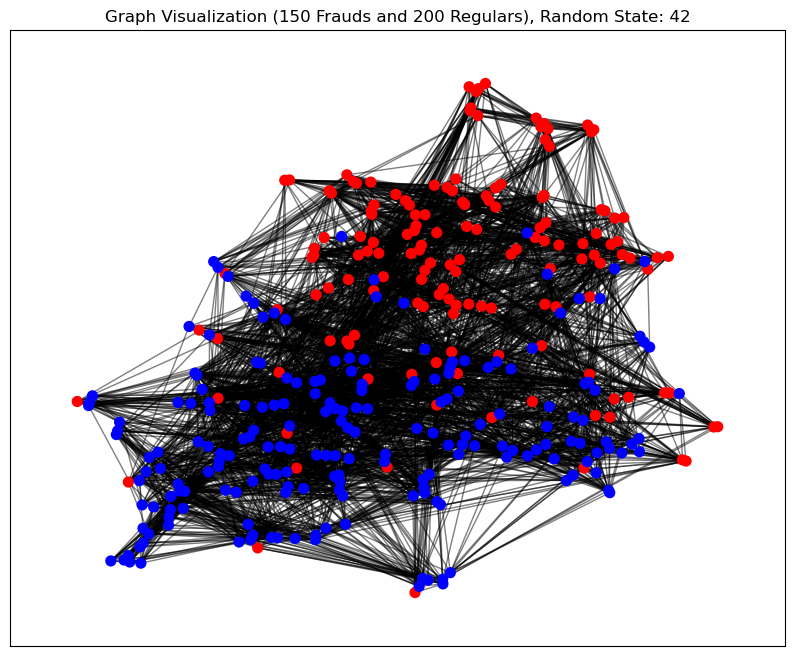

In [197]:
# Drop rows with missing values in selected features
df_graph = data3.dropna()

# Separate frauds and regular users
frauds = df_graph[df_graph['GB_flag'] == 1].head(150)
regulars = df_graph[df_graph['GB_flag'] == 0].head(200)

# Combine selected samples
selected_samples = pd.concat([frauds, regulars])

# Standardize the selected features
scaler = StandardScaler()
X = scaler.fit_transform(selected_samples.drop('GB_flag', axis=1)) # Exclude GB_flag from features

# Create a k-NN graph
k = 15
adj_matrix = kneighbors_graph(X, n_neighbors=k, mode='connectivity', include_self=False)

# Convert adjacency matrix to edge index format
edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)

# Convert node features to PyTorch tensor
x = torch.tensor(X, dtype=torch.float)

# Create PyTorch Geometric graph data object
graph_data = Data(x=x, edge_index=edge_index)

# Convert PyTorch Geometric graph to networkx graph
G = nx.Graph()
for i in range(graph_data.x.size(0)):
    G.add_node(i)
for i, j in graph_data.edge_index.t().tolist():
    G.add_edge(i, j)

# Set a random state for reproducibility
random_state = 42
tsne = TSNE(n_components=2, random_state=random_state, perplexity=5)
node_positions = tsne.fit_transform(graph_data.x.numpy())

# Visualize the graph
plt.figure(figsize=(10, 8))

# Color nodes based on GB_flag
colors = ['red' if gb == 1 else 'blue' for gb in selected_samples['GB_flag']]
nx.draw_networkx_nodes(G, pos=node_positions, node_size=50, node_color=colors)
nx.draw_networkx_edges(G, pos=node_positions, alpha=0.5)

plt.title(f"Graph Visualization (150 Frauds and 200 Regulars), Random State: {random_state}") # Add random state to title
plt.show()

## Модель на графах

In [40]:


# ✅ Drop missing values
data3_clean = data3.dropna()

# ✅ Separate features and target
X = data3_clean.drop(columns=["GB_flag"]).values
y = data3_clean["GB_flag"].values

# ✅ Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ✅ Print list of used features
used_features = data3_clean.drop(columns=["GB_flag"]).columns.tolist()
print("\n📌 Used features:")
for i, feature in enumerate(used_features, 1):
    print(f"{i:>2}. {feature}")

# ✅ Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ✅ Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# ✅ Create k-NN graph for training set
k = 15
adj_matrix_train = kneighbors_graph(X_train, n_neighbors=k, mode='connectivity', include_self=False)
edge_index_train = np.array(adj_matrix_train.nonzero())
num_nodes_train = X_train.shape[0]
num_features = X_train.shape[1]
hidden_dim = 16
num_classes = len(np.unique(y_train))
edge_index_train = edge_index_train[:, (edge_index_train[0] < num_nodes_train) & (edge_index_train[1] < num_nodes_train)]

x_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
edge_index_train_tensor = torch.tensor(edge_index_train, dtype=torch.long)

# ✅ Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# ✅ Create k-NN graph for TEST set
adj_matrix_test = kneighbors_graph(X_test, n_neighbors=k, mode='connectivity', include_self=False)
edge_index_test = np.array(adj_matrix_test.nonzero())
num_nodes_test = X_test.shape[0]
edge_index_test = edge_index_test[:, (edge_index_test[0] < num_nodes_test) & (edge_index_test[1] < num_nodes_test)]

x_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
edge_index_test_tensor = torch.tensor(edge_index_test, dtype=torch.long)

# ✅ Training function
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(x_train_tensor, edge_index_train_tensor)
    loss = F.nll_loss(out, y_train_tensor, weight=class_weights)
    loss.backward()
    optimizer.step()
    return loss.item()

# ✅ Evaluation function (now with F1)
def test(model):
    model.eval()
    with torch.no_grad():
        out = model(x_test_tensor, edge_index_test_tensor)
        pred_probs = out.exp()[:, 1].numpy()
        pred_labels = out.argmax(dim=1).numpy()

    if len(np.unique(y_test)) < 2:
        print("Skipping AUC, Gini, KS2 due to single-class test set.")
        return None

    auc_score = roc_auc_score(y_test, pred_probs)
    gini_index = 2 * auc_score - 1
    precision = precision_score(y_test, pred_labels, zero_division=0)
    recall = recall_score(y_test, pred_labels, zero_division=0)
    accuracy = accuracy_score(y_test, pred_labels)
    f1 = f1_score(y_test, pred_labels, zero_division=0)
    ks_statistic, _ = ks_2samp(pred_probs[y_test == 1], pred_probs[y_test == 0])

    return {
        "AUC": auc_score,
        "Gini": gini_index,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F1": f1,
        "KS2": ks_statistic
    }

# ✅ Experiment with different weight decay values
weight_decay_values = [0, 0.001, 0.01, 1, 0.1, 0.025, 0.5]
best_recall = 0
best_weight_decay = None
results = {}

for wd in weight_decay_values:
    print(f"\n🔹 Training with weight decay: {wd}")
    model = GCN(num_features, hidden_dim, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=wd)

    for epoch in range(50):
        loss = train(model, optimizer)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    metrics = test(model)
    if metrics:
        results[wd] = metrics
        print(f"AUC: {metrics['AUC']:.4f}, Gini: {metrics['Gini']:.4f}, Precision: {metrics['Precision']:.4f}, "
              f"Recall: {metrics['Recall']:.4f}, F1: {metrics['F1']:.4f}, Accuracy: {metrics['Accuracy']:.4f}, KS2: {metrics['KS2']:.4f}")

        if metrics["Recall"] > best_recall:
            best_recall = metrics["Recall"]
            best_weight_decay = wd

# ✅ Final result
print(f"\n🔥 Best weight decay: {best_weight_decay} with Recall: {best_recall:.4f}")



📌 Used features:
 1. total_amount_kzt
 2. overdueinstalmentcount_po_subektu
 3. term
 4. was_canceled
 5. GENDER
 6. CLASSIFICATION
 7. RESIDENCY
 8. EDUCATION
 9. MARITALSTATUS
10. NEGATIVESTATUS
11. PROFESSION
12. ECONOMYACTIVITYGROUP
13. EMPLOYMENTNATURE
14. DEPENDANTS_LT18
15. DEPENDANTS_GT18
16. AGE
17. NUM_CONTRACT_BVU
18. NUM_CONTRACT_MFO
19. NUM_CONTRACT_PDL
20. NUM_CONTRACT_OTHERS
21. NUM_COLLATERAL
22. NUM_USAGES
23. CNT_3D
24. CNT_1M
25. CNT_3M
26. CNT_6M
27. MAX_PEAKS_OVERDUECOUNT_LAST_2Y
28. MEAN_PEAKS_OVERDUECOUNT_LAST_2Y
29. MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y
30. SUM_SIG_PEAKS_OVERDUECOUNT_LAST_2Y
31. MONTH_OVERDUE_C0
32. MONTH_OVERDUE_C1
33. MONTH_OVERDUE_C2
34. MONTH_OVERDUE_C3
35. MONTH_OVERDUE_C4
36. MONTH_OVERDUE_C5
37. MONTH_OVERDUE_C6
38. MONTH_OVERDUE_C7
39. MONTH_OVERDUE_C8
40. MONTH_OVERDUE_C9
41. MONTH_OVERDUE_C10
42. MONTH_OVERDUE_C11
43. MONTH_OVERDUE_C12
44. MONTH_OVERDUE_C13
45. MONTH_OVERDUE_C14
46. MONTH_OVERDUE_C15
47. MONTH_OVERDUE_C16
48. MONTH_OVER

# Приложение 6 часть
## Логистическая модель
В качестве интерпретируемой модели была использована Логистическая регрессия, в которой мы использовали переменные на основе Борута и IV. Тем не менее модель все равно подвергалась сильной мультиколлинеарности, вследствие чего мы решили убрать наиболее коррелирующие переменные по VIF. Вдобавок, мы использовали маржинальные эффекты для упрощения интерпретации коэффицентов.

In [17]:
X = data3.drop(columns=["GB_flag"])
y = data3["GB_flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train_selected = X_train[selected]
X_test_selected = X_test[selected]

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_selected.values, i) for i in range(len(X_train_selected.columns))]
print(vif_data.sort_values(by="VIF", ascending=False))


                                feature         VIF
29                     EMPLOYMENTNATURE  414.753722
23                           PROFESSION  361.659215
36                            frequency  125.145463
2                        NUM_COLLATERAL   99.691961
4                     MONTH_OVERDUE_A21   39.477258
34                     MONTH_OVERDUE_A2   32.734387
8                     MONTH_OVERDUE_A18   32.526785
13      MEAN_PEAKS_OVERDUECOUNT_LAST_2Y   30.641570
11                                  AGE   27.382297
17  MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y   27.259279
9                      MONTH_OVERDUE_A0   25.566110
15                            rfm_score   18.859752
33                     MONTH_OVERDUE_A1   14.305574
18                     dependants_total   14.186733
1              NUM_MONTH_FROM_START_MAX   12.241631
14                               CNT_3M   10.859908
28                               CNT_6M   10.349921
27       MAX_PEAKS_OVERDUECOUNT_LAST_2Y    9.126543
10          

In [219]:
high_vif_features = [
    "dependants_total", "DEPENDANTS_GT18", "dependants_ratio", 
    "frequency", "NUM_COLLATERAL", "MONTH_OVERDUE_A18"
]

X_train_selected = X_train_selected.drop(columns=high_vif_features, errors='ignore')
X_test_selected = X_test_selected.drop(columns=high_vif_features, errors='ignore')


vif_data = pd.DataFrame()
vif_data["feature"] = X_train_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_selected.values, i) for i in range(X_train_selected.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))


                                feature        VIF
24                     EMPLOYMENTNATURE  44.778951
9       MEAN_PEAKS_OVERDUECOUNT_LAST_2Y  30.616985
7                                   AGE  27.411497
13  MEAN_SIG_PEAKS_OVERDUECOUNT_LAST_2Y  27.258720
29                     MONTH_OVERDUE_A2  23.437726
11                            rfm_score  18.977670
5                      MONTH_OVERDUE_A0  15.594037
28                     MONTH_OVERDUE_A1  13.859514
1              NUM_MONTH_FROM_START_MAX  12.009946
10                               CNT_3M  10.858487
23                               CNT_6M  10.343552
22       MAX_PEAKS_OVERDUECOUNT_LAST_2Y   9.108430
2                                 loans   8.112134
25                           NUM_USAGES   7.270218
19                     MONTH_OVERDUE_C0   6.836574
16                     MONTH_OVERDUE_C1   6.621158
30   SUM_SIG_PEAKS_OVERDUECOUNT_LAST_2Y   6.472412
17                     NUM_CONTRACT_BVU   5.993087
3                     MONTH_OVE

## Результаты интерпретируемой модели  

Логистическая регрессия демонстрирует, как переменные влияют на вероятность события (намеренного невозврата кредита). Обычный summary логистической модели не всегда удобен для интерпретации, поэтому были рассчитаны маржинальные эффекты коэффициентов. Интерпретация маржинальных эффектов аналогична линейным моделям, но с тем отличием, что они оценивают влияние факторов на вероятность положительного исхода (в нашем случае – невозврата кредита).  

### Ключевые результаты  

- **Чем выше RFM-score, тем выше вероятность невозврата кредита.**  
- **Более высокий уровень образования увеличивает вероятность невозврата кредита (при условии, что больший числовой код в переменной соответствует более высокому уровню образования).**  
- **Занятость в определенных отраслях экономики может быть связана с повышенным риском невозврата.**  
- **С увеличением возраста вероятность невозврата кредита уменьшается.**  
- **Чем больше запросов на кредит за последние 3 месяца, тем ниже вероятность невозврата.**  
- **Чем больше кредитов в других финансовых организациях, тем ниже вероятность невозврата.**  
- **Высокие просрочки в прошлом связаны с высокой вероятностью невозврата.**  
- **Чем больше контрактов в банках второго уровня (БВУ), тем ниже вероятность невозврата.**  
- **Наличие кредитов в иностранной валюте повышает вероятность невозврата.**  
- **Наличие рассрочек связано с повышенным риском невозврата.**  
- **Чем дольше срок кредита, тем выше вероятность невозврата.**  
- **Количество прошлых и текущих просрочек, а также их сумма положительно коррелируют с вероятностью невозврата кредита.**  

Большинство закономерностей логичны и ожидаемы. Однако некоторые результаты могут противоречить первоначальным гипотезам.  

### Объяснение неожиданных результатов  

#### Чем больше запросов на кредит за последние 3 месяца, тем ниже вероятность невозврата  
Возможно, в эту группу входят заемщики, которым были одобрены все поданные заявки. Это свидетельствует о хорошем кредитном рейтинге и высокой платежеспособности, что снижает риск дефолта.  

#### Чем больше кредитов в других финансовых организациях, тем ниже вероятность невозврата  
Это может означать, что банки и МФО тщательно оценивают заемщиков перед выдачей кредитов. Клиенты с плохой кредитной историей либо не получают новые кредиты, либо их количество ограничено.  

#### Наличие кредитов в иностранной валюте повышает вероятность невозврата  
Это закономерно, так как валютные кредиты подвержены риску колебаний обменного курса. Рост курса может резко увеличить долговую нагрузку заемщика, что повышает вероятность дефолта.  

#### Чем дольше срок кредита, тем выше вероятность невозврата  
Возможное объяснение: при выдаче долгосрочного кредита банк может предъявлять менее жесткие требования к уровню дохода заемщика, полагая, что более низкие ежемесячные платежи обеспечат его платежеспособность. Однако заемщики, планирующие мошенничество или изначально не собирающиеся возвращать кредит, не рассматривают долгосрочные риски и могут не обращать внимания на срок займа.  


In [19]:
y_train = y_train.astype(int)
X_train_selected_logit = sm.add_constant(X_train_selected)

class_weights = (1 / np.bincount(y_train))  

logit_model = sm.Logit(y_train, X_train_selected_logit).fit(cov_type="HC0", weights=class_weights)


print(logit_model.summary().as_text())








Optimization terminated successfully.
         Current function value: 0.034579
         Iterations 17
                           Logit Regression Results                           
Dep. Variable:                GB_flag   No. Observations:                50754
Model:                          Logit   Df Residuals:                    50716
Method:                           MLE   Df Model:                           37
Date:                Sun, 06 Apr 2025   Pseudo R-squ.:                  0.2471
Time:                        12:48:53   Log-Likelihood:                -1755.0
converged:                       True   LL-Null:                       -2330.9
Covariance Type:                  HC0   LLR p-value:                1.107e-217
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -2.0634      7.128

        Logit Marginal Effects       
Dep. Variable:                GB_flag
Method:                          dydx
At:                           overall
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
MARITALSTATUS                              nan        nan        nan        nan         nan         nan
NUM_MONTH_FROM_START_MAX                   nan        nan        nan        nan         nan         nan
NUM_COLLATERAL                             nan        nan        nan        nan         nan         nan
loans                                      nan        nan        nan        nan         nan         nan
MONTH_OVERDUE_A21                          nan        nan        nan        nan         nan         nan
dependants_ratio                           nan        nan        nan        nan         nan         nan
DEPENDANTS_GT18 

## Метрики Логистической модели
В целом, результаты уступают во многом XGBoost и нейронным сетям. Несмотря на это, модель все также может демонстрировать взаимотношение между на переменными.

In [26]:
from sklearn.metrics import f1_score

y_pred_proba = logit_model.predict(sm.add_constant(X_test_selected))
y_pred = (y_pred_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred_proba)
gini_index = 2 * roc_auc - 1

ks_statistic = ks_2samp(y_pred_proba[y_test == 1], y_pred_proba[y_test == 0]).statistic

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Вывод результатов
print(f"Gini Index: {gini_index:.4f}")
print(f"Kolmogorov-Smirnov: {ks_statistic:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Gini Index: 0.6866
Kolmogorov-Smirnov: 0.5731
Accuracy: 0.9932
Precision: 0.8000
Recall: 0.1871
F1 Score: 0.3033
